In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import os
from typing import List, Dict, Any, Tuple
import pandas as pd
import json
from functools import reduce
from itertools import chain
import numpy as np

# LOAD

In [ ]:
# %load ../subtask_1_2a.py
import pdb
import json
import logging.handlers
import argparse
import os
import numpy as np
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from networkx import DiGraph, relabel_nodes, all_pairs_shortest_path_length
from sklearn_hierarchical_classification.constants import ROOT
from sklearn_hierarchical_classification.metrics import h_fbeta_score, h_recall_score, h_precision_score, \
    fill_ancestors, multi_labeled
import sys
from typing import List, Dict
sys.path.append('.')


KEYS = ['id', 'labels']
logger = logging.getLogger("subtask_1_2a_scorer")
ch = logging.StreamHandler(sys.stdout)
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger.setLevel(logging.INFO)
# logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)

G = DiGraph()
G.add_edge(ROOT, "Logos")
G.add_edge("Logos", "Repetition")
G.add_edge("Logos", "Obfuscation, Intentional vagueness, Confusion")
G.add_edge("Logos", "Reasoning")
G.add_edge("Logos", "Justification")
G.add_edge('Justification', "Slogans")
G.add_edge('Justification', "Bandwagon")
G.add_edge('Justification', "Appeal to authority")
G.add_edge('Justification', "Flag-waving")
G.add_edge('Justification', "Appeal to fear/prejudice")
G.add_edge('Reasoning', "Simplification")
G.add_edge('Simplification', "Causal Oversimplification")
G.add_edge('Simplification', "Black-and-white Fallacy/Dictatorship")
G.add_edge('Simplification', "Thought-terminating cliché")
G.add_edge('Reasoning', "Distraction")
G.add_edge('Distraction', "Misrepresentation of Someone's Position (Straw Man)")
G.add_edge('Distraction', "Presenting Irrelevant Data (Red Herring)")
G.add_edge('Distraction', "Whataboutism")
G.add_edge(ROOT, "Ethos")
G.add_edge('Ethos', "Appeal to authority")
G.add_edge('Ethos', "Glittering generalities (Virtue)")
G.add_edge('Ethos', "Bandwagon")
G.add_edge('Ethos', "Ad Hominem")
G.add_edge('Ethos', "Transfer")
G.add_edge('Ad Hominem', "Doubt")
G.add_edge('Ad Hominem', "Name calling/Labeling")
G.add_edge('Ad Hominem', "Smears")
G.add_edge('Ad Hominem', "Reductio ad hitlerum")
G.add_edge('Ad Hominem', "Whataboutism")
G.add_edge(ROOT, "Pathos")
G.add_edge('Pathos', "Exaggeration/Minimisation")
G.add_edge('Pathos', "Loaded Language")
G.add_edge('Pathos', "Appeal to (Strong) Emotions")
G.add_edge('Pathos', "Appeal to fear/prejudice")
G.add_edge('Pathos', "Flag-waving")
G.add_edge('Pathos', "Transfer")


hier = {
    ROOT: ["Logos", "Ethos", "Pathos"],
    "Logos": ["Repetition", "Obfuscation, Intentional vagueness, Confusion", "Reasoning", "Justification"],
    "Justification": [
        "Slogans",
        "Bandwagon",
        "Appeal to authority",
        "Flag-waving",
        "Appeal to fear/prejudice",
    ],
    "Reasoning": [
        "Simplification",
        "Distraction",
    ],
    "Simplification": [
        "Causal Oversimplification",
        "Black-and-white Fallacy/Dictatorship",
        "Thought-terminating cliché",
    ],
    "Distraction": [
        "Misrepresentation of Someone's Position (Straw Man)",
        "Presenting Irrelevant Data (Red Herring)",
        "Whataboutism",
    ],
    "Ethos": [
        "Appeal to authority",
        "Glittering generalities (Virtue)",
        "Bandwagon",
        "Ad Hominem",
        "Transfer",
    ],
    "Ad Hominem": [
        "Doubt",
        "Name calling/Labeling",
        "Smears",
        "Reductio ad hitlerum",
        "Whataboutism",
    ],
    "Pathos": [
        "Exaggeration/Minimisation",
        "Loaded Language",
        "Appeal to (Strong) Emotions",
        "Appeal to fear/prejudice",
        "Flag-waving",
        "Transfer",
    ]
}
all_labels = []
for k, v in hier.items():
    all_labels.extend(v)
    all_labels = list(set(all_labels))


def get_dag_labels() -> List[str]:
    return all_labels


def get_dag() -> DiGraph:
    return G


def get_all_classes_from_graph(graph):
    return [
        node
        for node in graph.nodes
        if node != ROOT
    ]


def _h_fbeta_score(y_true, y_pred, class_hierarchy, beta=1., root=ROOT):
    hP = _h_precision_score(y_true, y_pred, class_hierarchy, root=root)
    hR = _h_recall_score(y_true, y_pred, class_hierarchy, root=root)
    return (1. + beta ** 2.) * hP * hR / (beta ** 2. * hP + hR)


def _fill_ancestors(y, graph, root, copy=True):
    y_ = y.copy() if copy else y
    paths = all_pairs_shortest_path_length(graph.reverse(copy=False))
    for target, distances in paths:
        if target == root:
            continue
        ix_rows = np.where(y[:, target] > 0)[0]
        ancestors = list(filter(lambda x: x != ROOT, distances.keys()))
        y_[tuple(np.meshgrid(ix_rows, ancestors))] = 1
    graph.reverse(copy=False)
    return y_


def _h_recall_score(y_true, y_pred, class_hierarchy, root=ROOT):
    y_true_ = _fill_ancestors(y_true, graph=class_hierarchy, root=root)
    y_pred_ = _fill_ancestors(y_pred, graph=class_hierarchy, root=root)

    ix = np.where((y_true_ != 0) & (y_pred_ != 0))

    true_positives = len(ix[0])
    all_positives = np.count_nonzero(y_true_)

    return true_positives / all_positives


def _h_precision_score(y_true, y_pred, class_hierarchy, root=ROOT):
    y_true_ = _fill_ancestors(y_true, graph=class_hierarchy, root=root)
    y_pred_ = _fill_ancestors(y_pred, graph=class_hierarchy, root=root)

    ix = np.where((y_true_ != 0) & (y_pred_ != 0))

    true_positives = len(ix[0])
    all_results = np.count_nonzero(y_pred_)

    return true_positives / all_results


def read_classes(file_path):
    CLASSES = []
    with open(file_path) as f:
        for label in f.readlines():
            label = label.strip()
            if label:
                CLASSES.append(label)
    return CLASSES


def check_format(file_path):
    _classes = get_all_classes_from_graph(G)
    if not os.path.exists(file_path):
        logging.error("File doesnt exists: {}".format(file_path))
        return False
    submmission = ''
    try:
        with open(file_path, encoding='utf-8') as p:
            submission = json.load(p)
    except BaseException:
        logging.error("File is not a valid json file: {}".format(file_path))
        return False
    for i, obj in enumerate(submission):
        for key in KEYS:
            if key not in obj:
                logging.error("Missing entry in {}:{}".format(file_path, i))
                return False
    for label in list(obj['labels']):
        if label not in _classes:
            print(label)
            logging.error("Unknown Label in {}:{}".format(file_path, i))
            return False
    return True


def _read_gold_and_pred(pred_fpath, gold_fpath):
    """
    Read gold and predicted data.
    :param pred_fpath: a json file with predictions,
    :param gold_fpath: the original annotated gold file.
    :return: {id:pred_labels} dict; {id:gold_labels} dict
    """

    gold_labels = {}
    with open(gold_fpath, encoding='utf-8') as gold_f:
        gold = json.load(gold_f)
        for obj in gold:
            gold_labels[obj['id']] = obj['labels']

    pred_labels = {}
    with open(pred_fpath, encoding='utf-8') as pred_f:
        pred = json.load(pred_f)
        for obj in pred:
            pred_labels[obj['id']] = obj['labels']

    if set(gold_labels.keys()) != set(pred_labels.keys()):
        logger.error(
            'There are either missing or added examples to the prediction file. Make sure you only have the gold examples in the prediction file.')
        raise ValueError(
            'There are either missing or added examples to the prediction file. Make sure you only have the gold examples in the prediction file.')

    return pred_labels, gold_labels


def evaluate_h(pred_fpath, gold_fpath):
    pred_labels, gold_labels = _read_gold_and_pred(pred_fpath, gold_fpath)

    gold = []
    pred = []
    for id in gold_labels:
        gold.append(gold_labels[id])
        pred.append(pred_labels[id])
    with multi_labeled(gold, pred, G) as (gold_, pred_, graph_):
        return _h_precision_score(
            gold_, pred_, graph_), _h_recall_score(
            gold_, pred_, graph_), _h_fbeta_score(
            gold_, pred_, graph_)


def validate_files(pred_files, gold_files):
    if not check_format(pred_files):
        logger.error('Bad format for pred file {}. Cannot score.'.format(pred_file))
        return False
    if not check_format(gold_files):
        logger.error('Bad format for gold file {}. Cannot score.'.format(gold_file))
        return False
    return True


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument(
#         "--gold_file_path",
#         '-g',
#         type=str,
#         required=True,
#         help="Paths to the file with gold annotations."
#     )
#     parser.add_argument(
#         "--pred_file_path",
#         '-p',
#         type=str,
#         required=True,
#         help="Path to the file with predictions"
#     )
#     parser.add_argument(
#         "--log_to_file",
#         "-l",
#         action='store_true',
#         default=False,
#         help="Set flag if you want to log the execution file. The log will be appended to <pred_file>.log"
#     )
#     args = parser.parse_args()

#     pred_file = args.pred_file_path
#     gold_file = args.gold_file_path

#     if args.log_to_file:
#         output_log_file = pred_file + ".log"
#         logger.info("Logging execution to file " + output_log_file)
#         fileLogger = logging.FileHandler(output_log_file)
#         fileLogger.setLevel(logging.DEBUG)
#         fileLogger.setFormatter(formatter)
#         logger.addHandler(fileLogger)
#         logger.setLevel(logging.DEBUG)

#     if args.log_to_file:
#         logger.info('Reading gold file')
#     else:
#         logger.info("Reading gold predictions from file {}".format(args.gold_file_path))
#     if args.log_to_file:
#         logger.info('Reading predictions file')
#     else:
#         logger.info('Reading predictions file {}'.format(args.pred_file_path))

#     if validate_files(pred_file, gold_file):
#         logger.info('Prediction file format is correct')
#         prec_h, rec_h, f1_h = evaluate_h(pred_file, gold_file)
#         logger.info("f1_h={:.5f}\tprec_h={:.5f}\trec_h={:.5f}".format(f1_h, prec_h, rec_h))
#         if args.log_to_file:
#             print("{}\t{}\t{}".format(f1_h, prec_h, rec_h))
#         else:
#             print("f1_h={:.5f}\tprec_h={:.5f}\trec_h={:.5f}".format(f1_h, prec_h, rec_h))


In [ ]:
# %load ./data.py
import json
import pandas as pd
from typing import List
# from src.utils.workspace import get_workdir

# DATASET_DIR = f"{get_workdir()}/dataset"
DATASET_DIR = "../dataset"


def _load_semeval2024() -> List[pd.DataFrame]:
    with open(f"{DATASET_DIR}/semeval2024/subtask1/train.json", "r") as f:
        train = pd.DataFrame().from_records(json.load(f))
    with open(f"{DATASET_DIR}/semeval2024/subtask1/validation.json", "r") as f:
        validation = pd.DataFrame().from_records(json.load(f))
    with open(f"{DATASET_DIR}/semeval2024/subtask1/dev_unlabeled.json", "r") as f:
        dev_unlabeled = pd.DataFrame().from_records(json.load(f))
    return train, validation, dev_unlabeled


def _load_ptc2019() -> List[pd.DataFrame]:
    train = pd.read_csv(f"{DATASET_DIR}/ptc_adjust/ptc_preproc_train.csv",
                        sep=";").dropna(subset=["text", "label"])[["text", "label"]]
    train = train.drop_duplicates(subset=["text"])
    test = pd.read_csv(f"{DATASET_DIR}/ptc_adjust/ptc_preproc_test.csv",
                       sep=";").dropna(subset=["text", "label"])[["text", "label"]]
    test = test.drop_duplicates(subset=["text"])
    dev = pd.read_csv(f"{DATASET_DIR}/ptc_adjust/ptc_preproc_dev.csv",
                      sep=";").dropna(subset=["text", "label"])[["text", "label"]]
    dev = dev.drop_duplicates(subset=["text"])

    def rename_label_column(df: pd.DataFrame) -> pd.DataFrame:
        df["labels"] = df["label"].str.split(",")
        df = df.drop(columns=["label"])
        return df

    train, test, dev = map(rename_label_column, [train, test, dev])
    return train, test, dev


def load_dataset(dataset: str) -> List[pd.DataFrame]:
    """Load a given dataset, returning splits

    Parameters:
    -----------
    dataset : str
              name of dataset, currently only 'ptc2019' or 'semeval2024' are supported

    Returns:
    --------
    List[pd.DataFrame]
              train, test and dev splits. They include the columns `text` (str) and `labels` (List[str])
    """
    if dataset == "semeval2024":
        return _load_semeval2024()
    elif dataset == "ptc2019":
        return _load_ptc2019()
    raise Exception(f"{dataset} is not available")


# MLPClassifier - PyTorch

In [ ]:
GOLD_PATH = "../dataset/semeval2024/subtask1/validation.json"
OUTPUT_DIR = "../classification"

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

args = Namespace(
    train_features = "../feature_extraction/1703941782_xlm-roberta-base_train_features.json",
    test_features = "../feature_extraction/1703941782_xlm-roberta-base_test_features.json",
    dev_features = "../feature_extraction/1703941782_xlm-roberta-base_dev_features.json",
    dataset = "semeval2024",
    classifier = "other",
    seed = 1)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class TextEmbeddingDataset(Dataset):
    def __init__(self, X, y):
        self.embedding_vectors = X
        self.labels = y

    def __len__(self):
        return len(self.embedding_vectors)

    def __getitem__(self, idx):
        sample = torch.from_numpy(self.embedding_vectors[idx]).float(), torch.from_numpy(self.labels[idx]).float()
        return sample

In [ ]:
    print("Loading dataset files")
    train, dev, test = load_dataset(args.dataset)
    print("Dataset Lengths", len(train), len(dev), len(test))

    train["labels"]

Loading dataset files
Dataset Lengths 7000 500 1000


0                  [Black-and-white Fallacy/Dictatorship]
1       [Loaded Language, Glittering generalities (Vir...
2                                                      []
3                                                      []
4                            [Thought-terminating cliché]
                              ...                        
6995    [Loaded Language, Causal Oversimplification, T...
6996                      [Loaded Language, Whataboutism]
6997                                                   []
6998                                                   []
6999                                            [Slogans]
Name: labels, Length: 7000, dtype: object

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import os
from typing import List, Dict, Any, Tuple
import pandas as pd
import json
from functools import reduce
from itertools import chain
import numpy as np
from sklearn.model_selection import train_test_split
import random
import torch

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def save_predictions(test_df: pd.DataFrame, predictions: List[List[str]], kind: str, classifier: str) -> Tuple[str, List[Dict[str, Any]]]:
    predictions_json = []
    for idx, row in test_df.iterrows():
        predictions_json.append({
            "id": row["id"],
            "labels": predictions[idx],
        })

    os.makedirs(OUTPUT_DIR, exist_ok=True)
    # submission format has txt extension but json format
    predictions_json_path = f"{OUTPUT_DIR}/{kind}_predictions_{classifier}.json.txt"
    with open(predictions_json_path, "w") as f:
        json.dump(predictions_json, f, indent=4)

    return predictions_json_path, predictions_json

def load_features_info(path: str) -> Dict[str, Any]:
    with open(path, "r") as f:
        return json.load(f)

def load_features_array(path: str) -> np.ndarray:
    with open(path, "r") as f:
        df = pd.DataFrame().from_records(json.load(f))
        # print(np.array(df).shape)
        return np.array(df)

def classify(args: Namespace):
    print(f'Using fixed random seed: {args.seed}')

    seed_everything(args.seed)

    print("Loading features info files")
    train_ft_info, dev_ft_info, test_ft_info = map(
        load_features_info, [
            args.train_features, args.dev_features, args.test_features])

    print("Loading dataset files")
    train, dev, test = load_dataset(args.dataset)
    print("Dataset Lengths", len(train), len(dev), len(test))

    all_labels = pd.concat([train["labels"], dev["labels"]])

    if args.classifier == "HiMLP":
        labels = [get_dag_labels()]
    else:
        labels = [list(set(reduce(lambda x, y: x + y, all_labels.to_numpy().tolist())))]
    print(f"Labels: {labels}")
    print(f"No. of labels in {'DAG' if args.classifier == 'HiMLP' else 'train+dev datasets'}: {len(labels[0])}")

    mlb = MultiLabelBinarizer(classes=labels[0])
    train_labels = mlb.fit(labels).transform(train["labels"].to_numpy())
    dev_labels = mlb.transform(dev["labels"].to_numpy())

    print("Loading features array files")
    train_ft, test_ft, dev_ft = map(
        load_features_array, [
            train_ft_info["features"], test_ft_info["features"], dev_ft_info["features"]])
    print("Features Lengths", len(train_ft), len(test_ft), len(dev_ft))

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(train_ft, train_labels, test_size=0.1, random_state=42)

    # Create instances of the train/test/dev datasets
    train_dataset = TextEmbeddingDataset(X_train, y_train)
    val_dataset = TextEmbeddingDataset(X_val, y_val)
    dev_dataset = TextEmbeddingDataset(dev_ft, dev_labels)

    return train_dataset, val_dataset, dev_dataset, mlb, labels

train_dataset, val_dataset, dev_dataset, mlb, leaf_labels = classify(args)

Using fixed random seed: 1
Loading features info files
Loading dataset files
Dataset Lengths 7000 500 1000
Labels: [['Obfuscation, Intentional vagueness, Confusion', 'Whataboutism', 'Presenting Irrelevant Data (Red Herring)', "Misrepresentation of Someone's Position (Straw Man)", 'Causal Oversimplification', 'Smears', 'Appeal to fear/prejudice', 'Black-and-white Fallacy/Dictatorship', 'Thought-terminating cliché', 'Name calling/Labeling', 'Slogans', 'Flag-waving', 'Loaded Language', 'Repetition', 'Reductio ad hitlerum', 'Exaggeration/Minimisation', 'Bandwagon', 'Appeal to authority', 'Doubt', 'Glittering generalities (Virtue)']]
No. of labels in train+dev datasets: 20
Loading features array files
Features Lengths 7000 1000 500


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np

seed_everything(args.seed)
batch_size = 200

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(dev_dataset, batch_size=batch_size)

# Define the neural network model
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(MultiLabelClassifier, self).__init__()
        self.fc = nn.Linear(input_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = 768  # Assuming 768-dimensional text embeddings
output_size = 20  # Number of labels
model = MultiLabelClassifier(input_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 400
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validate the model
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

        val_loss /= len(val_loader)
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}")

/home/ebezerra/anaconda3/envs/bambas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/400, Validation Loss: 0.2949240878224373
Epoch 2/400, Validation Loss: 0.2642063945531845
Epoch 3/400, Validation Loss: 0.25818901509046555
Epoch 4/400, Validation Loss: 0.2555961087346077
Epoch 5/400, Validation Loss: 0.25333284959197044
Epoch 6/400, Validation Loss: 0.2514684125781059
Epoch 7/400, Validation Loss: 0.2502719350159168
Epoch 8/400, Validation Loss: 0.24861587956547737
Epoch 9/400, Validation Loss: 0.2475341185927391
Epoch 10/400, Validation Loss: 0.24642258882522583
Epoch 11/400, Validation Loss: 0.24522385001182556
Epoch 12/400, Validation Loss: 0.24416539072990417
Epoch 13/400, Validation Loss: 0.2430606707930565
Epoch 14/400, Validation Loss: 0.24236207827925682
Epoch 15/400, Validation Loss: 0.24147078767418861
Epoch 16/400, Validation Loss: 0.24077168852090836
Epoch 17/400, Validation Loss: 0.23984159529209137
Epoch 18/400, Validation Loss: 0.23895276337862015
Epoch 19/400, Validation Loss: 0.23840047419071198
Epoch 20/400, Validation Loss: 0.23788655549287

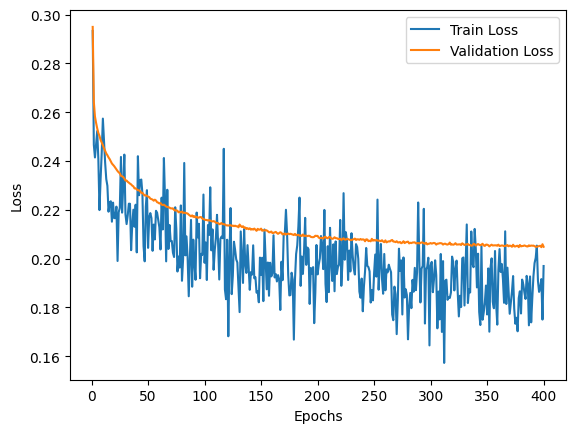

In [ ]:
import matplotlib.pyplot as plt

# Plot the train and validation loss values
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Error Analysis

In [ ]:
leaf_labels[0], len(leaf_labels[0])

(['Obfuscation, Intentional vagueness, Confusion',
  'Whataboutism',
  'Presenting Irrelevant Data (Red Herring)',
  "Misrepresentation of Someone's Position (Straw Man)",
  'Causal Oversimplification',
  'Smears',
  'Appeal to fear/prejudice',
  'Black-and-white Fallacy/Dictatorship',
  'Thought-terminating cliché',
  'Name calling/Labeling',
  'Slogans',
  'Flag-waving',
  'Loaded Language',
  'Repetition',
  'Reductio ad hitlerum',
  'Exaggeration/Minimisation',
  'Bandwagon',
  'Appeal to authority',
  'Doubt',
  'Glittering generalities (Virtue)'],
 20)

In [ ]:
import torch
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np

# Set the model to evaluation mode
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Convert the outputs and labels to numpy arrays
        predictions = (outputs.cpu().numpy() > 0.5).astype(int)
        labels_np = labels.cpu().numpy()

        all_predictions.append(predictions)
        all_labels.append(labels_np)

# Concatenate predictions and labels along the samples axis
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Compute the multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(all_labels, all_predictions)

# Print the confusion matrices
for i, matrix in enumerate(confusion_matrices):
    print(f"Confusion Matrix for '{leaf_labels[0][i]}':\n{matrix}")

# In a multilabel confusion matrix:
# - true negatives count is at 00,
# - false negatives count is at 10,
# - true positives count is at 11
# - false positives count is at 01.
# see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html

Confusion Matrix for 'Obfuscation, Intentional vagueness, Confusion':
[[498   0]
 [  2   0]]
Confusion Matrix for 'Whataboutism':
[[479   0]
 [ 21   0]]
Confusion Matrix for 'Presenting Irrelevant Data (Red Herring)':
[[496   0]
 [  4   0]]
Confusion Matrix for 'Misrepresentation of Someone's Position (Straw Man)':
[[496   0]
 [  4   0]]
Confusion Matrix for 'Causal Oversimplification':
[[479   0]
 [ 21   0]]
Confusion Matrix for 'Smears':
[[330  28]
 [104  38]]
Confusion Matrix for 'Appeal to fear/prejudice':
[[473   0]
 [ 27   0]]
Confusion Matrix for 'Black-and-white Fallacy/Dictatorship':
[[444   3]
 [ 52   1]]
Confusion Matrix for 'Thought-terminating cliché':
[[459   3]
 [ 37   1]]
Confusion Matrix for 'Name calling/Labeling':
[[376   8]
 [100  16]]
Confusion Matrix for 'Slogans':
[[447   3]
 [ 50   0]]
Confusion Matrix for 'Flag-waving':
[[455   3]
 [ 37   5]]
Confusion Matrix for 'Loaded Language':
[[339  26]
 [104  31]]
Confusion Matrix for 'Repetition':
[[477   0]
 [ 22   1]]

In [ ]:
all_predictions.shape, all_labels.shape

((500, 20), (500, 20))

In [ ]:
mlb.inverse_transform(all_labels)

[('Slogans', 'Doubt'),
 ('Smears', 'Exaggeration/Minimisation'),
 ('Thought-terminating cliché',),
 ('Glittering generalities (Virtue)',),
 ('Thought-terminating cliché', 'Slogans', 'Appeal to authority'),
 ('Name calling/Labeling', 'Flag-waving', 'Loaded Language'),
 (),
 ('Smears',),
 ('Flag-waving',),
 ('Name calling/Labeling', 'Appeal to authority'),
 ('Loaded Language', 'Appeal to authority'),
 ('Black-and-white Fallacy/Dictatorship',),
 ('Smears',),
 ('Thought-terminating cliché', 'Name calling/Labeling', 'Loaded Language'),
 ('Name calling/Labeling',
  'Flag-waving',
  'Exaggeration/Minimisation',
  'Appeal to authority'),
 ('Name calling/Labeling',),
 ('Smears',),
 ('Smears', 'Name calling/Labeling', 'Glittering generalities (Virtue)'),
 ('Name calling/Labeling', 'Loaded Language', 'Doubt'),
 ('Loaded Language', 'Doubt'),
 ('Slogans',),
 (),
 ('Name calling/Labeling', 'Repetition', 'Appeal to authority'),
 ('Doubt',),
 ('Thought-terminating cliché',),
 ('Loaded Language',),
 ('

In [ ]:
mlb.inverse_transform(all_predictions)


[('Appeal to authority',),
 (),
 (),
 (),
 (),
 ('Loaded Language', 'Appeal to authority'),
 (),
 ('Slogans',),
 (),
 (),
 ('Appeal to authority',),
 (),
 ('Smears',),
 ('Smears', 'Name calling/Labeling', 'Loaded Language'),
 ('Appeal to authority',),
 ('Smears',),
 ('Smears',),
 ('Name calling/Labeling',),
 (),
 (),
 (),
 (),
 ('Loaded Language', 'Repetition', 'Appeal to authority'),
 (),
 (),
 (),
 (),
 ('Smears',),
 (),
 ('Slogans',),
 ('Loaded Language',),
 ('Loaded Language',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('Smears', 'Loaded Language'),
 (),
 (),
 ('Loaded Language',),
 (),
 (),
 (),
 (),
 (),
 ('Loaded Language',),
 ('Smears',),
 ('Smears',),
 ('Glittering generalities (Virtue)',),
 (),
 (),
 ('Appeal to authority',),
 (),
 ('Name calling/Labeling',),
 (),
 (),
 (),
 (),
 (),
 ('Appeal to authority',),
 (),
 (),
 ('Smears', 'Loaded Language'),
 (),
 (),
 ('Smears', 'Loaded Language'),
 ('Loaded Language',),
 (),
 ('Slogans', 'Fl

In [ ]:
_, dev, _ = load_dataset(args.dataset)

# Creating a pandas DataFrame
df_error_analysis = pd.DataFrame({'Text': dev.text, 'Actual': mlb.inverse_transform(all_labels), 'Predicted': mlb.inverse_transform(all_predictions)})

# Displaying the DataFrame
df_error_analysis.head(50)

,Text,Actual,Predicted
0,Critical Thinking Essentials\n\Are my biases a...,"(Slogans, Doubt)","(Appeal to authority,)"
1,Trying to think of a single accomplishment...,"(Smears, Exaggeration/Minimisation)",()
2,Corporate needs you to find the difference bet...,"(Thought-terminating cliché,)",()
3,KYLE RITTENHOUSE\nALL CHARGES\nNOT GUILTY,"(Glittering generalities (Virtue),)",()
4,Al Franken explains why America should tax the...,"(Thought-terminating cliché, Slogans, Appeal t...",()
5,\ I left my parents. I left my brothers and si...,"(Name calling/Labeling, Flag-waving, Loaded La...","(Loaded Language, Appeal to authority)"
6,"Grandson: Grandpa, whats that thing on the wal...",(),()
7,"President Obama,\nWe Built It-You Broke It - W...","(Smears,)","(Slogans,)"
8,A SINGLE-PHOTO DEPICTION\n\nOF HOW MUCH PRESID...,"(Flag-waving,)",()
9,ORWELL CALLED THEM \THOUGHT POLICE\\n\n\nBIG T...,"(Name calling/Labeling, Appeal to authority)",()


In [ ]:
lbl_of_interest = 'Appeal to authority'
# lbl_of_interest = 'Whataboutism'
# lbl_of_interest = 'Obfuscation, Intentional vagueness, Confusion'

# Selecting rows containing the label of interest in any column
result_df = df_error_analysis[df_error_analysis.apply(lambda row: row.astype(str).str.contains(lbl_of_interest).any(), axis=1)]
print(result_df.shape)
result_df.head(50)
result_df.to_csv('Appeal_to_authority.csv')

(74, 3)


In [ ]:
# Selecting rows containing the given label in the selected column

# lbl_of_interest = 'Whataboutism' # idx = 1
lbl_of_interest = 'Smears' # idx = 5

col_of_interest = 'Actual'
result_df = df_error_analysis[df_error_analysis[col_of_interest].apply(lambda tup: lbl_of_interest in (','.join([str(x) for x in tup])))]
print(result_df.shape)
result_df.head(50)

(142, 3)


,Text,Actual,Predicted
1,Trying to think of a single accomplishment...,"(Smears, Exaggeration/Minimisation)",()
7,"President Obama,\nWe Built It-You Broke It - W...","(Smears,)","(Slogans,)"
12,Everyone is all excited that after 4 years the...,"(Smears,)","(Smears,)"
16,ALEXANDRA OCASIO-CORTEZ\n\nWAS FIRED FROM \HOT...,"(Smears,)","(Smears,)"
17,"The composure, poise and grace that Ketanji Br...","(Smears, Name calling/Labeling, Glittering gen...","(Name calling/Labeling,)"
27,Who sank the Titanic?\n\nA pro-Russian submari...,"(Smears, Name calling/Labeling, Loaded Language)","(Smears,)"
37,The England Football team visited an orphanage...,"(Smears, Exaggeration/Minimisation)",()
42,OBAMA AND PUTIN ARE BOTH WORKING TOWARD THE SA...,"(Smears, Loaded Language, Reductio ad hitlerum)",()
44,DONALD TRUMP\nIS A\nRA IST\nC P\n,"(Smears,)",()
46,DON'T WAIT.\nVACCINATE.\nWE WERE ALL STUPID YO...,"(Smears, Name calling/Labeling)",()


In [ ]:
# M. Heydarian, T. Doyle, and R. Samavi, MLCM: Multi-Label Confusion Matrix, IEEE Access, Feb. 2022, DOI: 10.1109/ACCESS.2022.3151048

# !pip install mlcm

In [ ]:
# import mlcm
import importlib

# make changes to example.py file

importlib.reload(mlcm)

<module 'mlcm.mlcm' from '/home/ebezerra/anaconda3/envs/bambas/lib/python3.12/site-packages/mlcm/mlcm.py'>

In [ ]:
from mlcm import mlcm

conf_mat,normal_conf_mat = mlcm.cm(y_true,y_pred)
print('\nRaw confusion Matrix:')
print(conf_mat)
print('\nNormalized confusion Matrix (%):')
print(normal_conf_mat)

MLCM has one extra row (NTL) and one extra column (NPL).        
Please read the following paper for more information:
        Heydarian et al., MLCM: Multi-Label Confusion Matrix, IEEE Access,2022        
To skip this message, please add parameter "print_note=False"
        e.g., conf_mat,normal_conf_mat = mlcm.cm(label_true,label_pred,False)

Raw confusion Matrix:
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  6  0  0  1  0  0  0  3  0  0  0  0  1  0  1 13]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  3]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  4  0  1  1  0  0  0  1  0  0  0  0  1  0  0 16]
 [ 0  0  0  0  0 38  0  0  1  2  1  0  9  0  0  0  0  3  2  3 93]
 [ 0  0  0  0  0  3  0  0  0  0  0  0  2  0  0  0  0  2  0  0 21]
 [ 0  0  0  0  0  1  0  1  0  2  1  1  2  0  0  0  0  2  0  1 43]
 [ 0  0  0  0  0  4  0  0  1  3  0  1  2  0  0  0  0  1  0  0 26]
 [ 0  0  0  0  0  6  0  1  0 16  0  0

In [ ]:
# pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 13.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


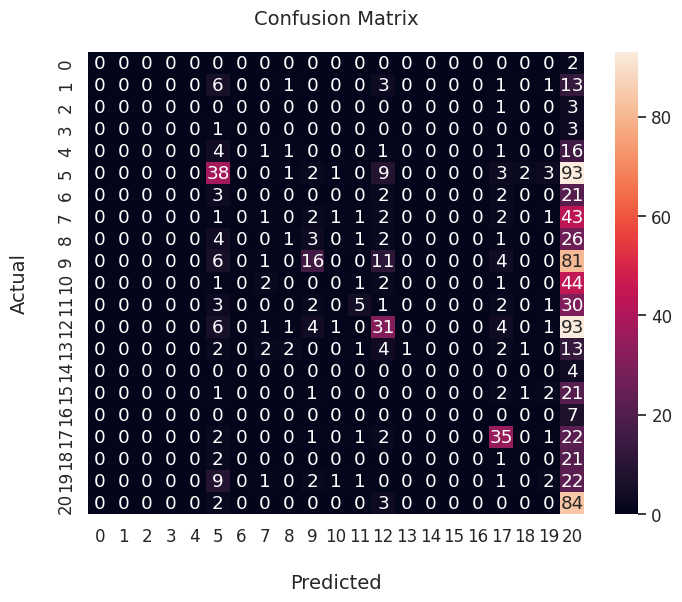

In [ ]:
import seaborn as sns

# Change figure size and increase dpi for better resolution
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers.
ax = sns.heatmap(conf_mat, annot=True, fmt='d', )

# set x-axis label and ticks.
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
# lbls = leaf_labels[0] + ["None"]
# ax.xaxis.set_ticklabels(lbls)

# set y-axis label and ticks
ax.set_ylabel("Actual", fontsize=14, labelpad=20)

# set plot title
ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show()

In [ ]:
# see https://stackoverflow.com/questions/68374999/is-this-the-correct-use-of-sklearn-classification-report-for-multi-label-classif

from sklearn.metrics import classification_report
import numpy as np

y_true, y_pred = all_labels, all_predictions

print(classification_report(y_true, y_pred, target_names=leaf_labels[0]))

                                                     precision    recall  f1-score   support

      Obfuscation, Intentional vagueness, Confusion       0.00      0.00      0.00         2
                                       Whataboutism       0.00      0.00      0.00        21
           Presenting Irrelevant Data (Red Herring)       0.00      0.00      0.00         4
Misrepresentation of Someone's Position (Straw Man)       0.00      0.00      0.00         4
                          Causal Oversimplification       0.00      0.00      0.00        21
                                             Smears       0.58      0.27      0.37       142
                           Appeal to fear/prejudice       0.00      0.00      0.00        27
               Black-and-white Fallacy/Dictatorship       0.25      0.02      0.04        53
                         Thought-terminating cliché       0.25      0.03      0.05        38
                              Name calling/Labeling       0.67      0

/home/ebezerra/anaconda3/envs/bambas/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ebezerra/anaconda3/envs/bambas/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ebezerra/anaconda3/envs/bambas/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

In [ ]:
_, dev, _ = load_dataset(args.dataset)
dev_predicted_labels = all_predictions
print(f"dev_predicted_labels.shape = {dev_predicted_labels.shape}")
print(f"dev.shape = {dev.shape}")

if args.classifier != "HiMLP":
    dev_predicted_labels = mlb.inverse_transform(dev_predicted_labels)

pred_path, _ = save_predictions(dev, dev_predicted_labels, "dev", args.classifier)
print(f"Finished successfully. val predictions saved at {pred_path}")

print()
prec, rec, f1 = evaluate_h(pred_path, GOLD_PATH)
print(f"\nValidation set:\n\tPrecision: {prec}\n\tRecall: {rec}\n\tF1: {f1}\n")

In [ ]:
import re

def extract_author(quote):
    # Define a regular expression pattern to match the author's name in quotes
    author_pattern = r'— (.+)$|(?<=\\")[^\\"]+(?=\\")'

    # Search for the pattern in the given quote
    match = re.search(author_pattern, quote)

    # If a match is found, return the author's name
    if match:
        return match.group(0).strip()

    # If no match is found, return None
    return None

# Examples
quote1 = "I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best. — Marilyn Monroe"

quote2 = 'Kurt Cobain quote from 1993\\n\\n\\In the end I believe my generation will surprise everyone. We already know that both political parties are playing both sides from the middle and we\'ll elect a true outsider when we fully mature. I wouldn\'t be surprised if it\'s not a business tycoon who can\'t be bought and who does what\'s right for the people. Someone like Donald Trump as crazy as that sounds.\\"'

# Extract authors
author1 = extract_author(quote1)
author2 = extract_author(quote2)

# Display results
print("Author 1:", author1)
print("Author 2:", author2)



Author 1: — Marilyn Monroe
Author 2: None


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
import re
from nltk import sent_tokenize, word_tokenize, pos_tag, ne_chunk

def extract_proper_nouns(text):
    # Using NLTK for named entity recognition to identify potential author names
    sentences = sent_tokenize(text)
    authors = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        pos_tags = pos_tag(words)
        named_entities = ne_chunk(pos_tags)
        for chunk in named_entities:
            if hasattr(chunk, 'label') and chunk.label() == 'PERSON':
                authors.append(' '.join(c[0] for c in chunk))

    return authors

text_examples = ['John and Mary went to the market. Steve joined them later.',
                 "I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best. — Marilyn Monroe",
                 'Kurt Cobain quote from 1993\\n\\n\\In the end I believe my generation will surprise everyone. We already know that both political parties are playing both sides from the middle and we\'ll elect a true outsider when we fully mature. I wouldn\'t be surprised if it\'s not a business tycoon who can\'t be bought and who does what\'s right for the people. Someone like Donald Trump as crazy as that sounds.\\"',
                 "When you look at serial number of your AK-47 and its the same one you had in Afganistan",
                 "BREAKING: Andrew Cuomo Will Be Arrested Next Week\\nFor Sex Crimes; Here's What We Know",
                 "Statistically, you're more likely to die from living under\\nsocialism than by an \\Assault Rifle.\\\\n- Reality"]

for text in text_examples:
  authors = extract_proper_nouns(text)
  print("Authors:", authors)
  print()

Authors: ['John', 'Mary', 'Steve']

Authors: ['Marilyn Monroe']

Authors: ['Kurt', 'Donald Trump']

Authors: []

Authors: ['Andrew Cuomo', 'Next']

Authors: []



In [ ]:
_, dev, _ = load_dataset(args.dataset)
dev.head()

NameError: name 'load_dataset' is not defined

In [ ]:
pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 28

In [ ]:
from flair.data import Sentence
from flair.models import SequenceTagger

# load tagger
tagger = SequenceTagger.load("flair/pos-english")

# make example sentence
sentence = Sentence("I love DONALD TRUMP.")

# predict NER tags
tagger.predict(sentence)

# print sentence
print(sentence)

print(sentence.get_spans('pos'))

# print predicted NER spans
print('The following NER tags are found:')
# iterate over entities and print
for entity in sentence.get_spans('pos'):
    print(entity)

2024-01-12 14:28:46,215 SequenceTagger predicts: Dictionary with 53 tags: <unk>, O, UH, ,, VBD, PRP, VB, PRP$, NN, RB, ., DT, JJ, VBP, VBG, IN, CD, NNS, NNP, WRB, VBZ, WDT, CC, TO, MD, VBN, WP, :, RP, EX, JJR, FW, XX, HYPH, POS, RBR, JJS, PDT, NNPS, RBS, AFX, WP$, -LRB-, -RRB-, ``, '', LS, $, SYM, ADD
Sentence[5]: "I love DONALD TRUMP." → ["I"/PRP, "love"/VBP, "DONALD"/NNP, "TRUMP"/NNP, "."/.]
[]
The following NER tags are found:


In [ ]:
text_examples = ['John and Mary went to the market. Steve joined them later.',
                 "I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best. — Marilyn Monroe",
                 'Kurt Cobain quote from 1993\\n\\n\\In the end I believe my generation will surprise everyone. We already know that both political parties are playing both sides from the middle and we\'ll elect a true outsider when we fully mature. I wouldn\'t be surprised if it\'s not a business tycoon who can\'t be bought and who does what\'s right for the people. Someone like Donald Trump as crazy as that sounds.\\"',
                 "When you look at serial number of your AK-47 and its the same one you had in Afganistan",
                 "BREAKING: Andrew Cuomo Will Be Arrested Next Week\\nFor Sex Crimes; Here's What We Know",
                 "Statistically, you're more likely to die from living under\\nsocialism than by an \\Assault Rifle.\\\\n- Reality",
                 "DONALD TRUMP MUST BE INDICTED. A FAILURE TO PROSECUTE TRUMP FOR HIS CONSPIRACY TO\nOVERTHROW OUR DEMOCRACY GUARANTEES FUTURE ATTEMPTS TO OVERTHROW OUR DEMOCRACY.\nGLENN KIRSCHNER"]

for text in text_examples

In [ ]:
# load tagger
tagger = SequenceTagger.load("flair/ner-english-large")

In [ ]:
from flair.data import Sentence
from flair.models import SequenceTagger

# make example sentence
sentence = Sentence("George Washington went to Washington")

# predict NER tags
tagger.predict(sentence)

# print sentence
print(sentence)

# print predicted NER spans
print('The following NER tags are found:')
# iterate over entities and print
for entity in sentence.get_spans('ner'):
    print(entity)


2024-01-12 14:31:44,871 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>
Sentence[5]: "George Washington went to Washington" → ["George Washington"/PER, "Washington"/LOC]
The following NER tags are found:
Span[0:2]: "George Washington" → PER (1.0)
Span[4:5]: "Washington" → LOC (1.0)


In [ ]:
text_examples = ['John and Mary went to the market. Steve joined them later.',
                 "I'm selfish, impatient and a little insecure. I make mistakes, I am out of control and at times hard to handle. But if you can't handle me at my worst, then you sure as hell don't deserve me at my best. — Marilyn Monroe",
                 'Kurt Cobain quote from 1993\\n\\n\\In the end I believe my generation will surprise everyone. We already know that both political parties are playing both sides from the middle and we\'ll elect a true outsider when we fully mature. I wouldn\'t be surprised if it\'s not a business tycoon who can\'t be bought and who does what\'s right for the people. Someone like Donald Trump as crazy as that sounds.\\"',
                 "When you look at serial number of your AK-47 and its the same one you had in Afganistan",
                 "BREAKING: Andrew Cuomo Will Be Arrested Next Week\\nFor Sex Crimes; Here's What We Know",
                 "Statistically, you're more likely to die from living under\\nsocialism than by an \\Assault Rifle.\\\\n- Reality",
                 "DONALD TRUMP MUST BE INDICTED. A FAILURE TO PROSECUTE TRUMP FOR HIS CONSPIRACY TO\nOVERTHROW OUR DEMOCRACY GUARANTEES FUTURE ATTEMPTS TO OVERTHROW OUR DEMOCRACY.\nGLENN KIRSCHNER",
                 "Dear America: You are waking up, as Germany once did, to the awareness that 1/3 of your people would kill\nanother 1/3, while 1/3 watches.\n\nWerner Herzog\n",
                 "SHOULD PRESIDENT TRUMP SIGN AN EXECUTIVE ORDER\n\nTO REQUIRE VOTER I.D. NATIONALLY TO VOTE IN THE\n2020 ELECTION?",
                 "Never forget: Attacks on the working class come from those who travel by private jet, not migrant dinghy.\\n\n- Zarah Sultana"]

for text in text_examples:
  # make example sentence
  sentence = Sentence(text)

  # predict NER tags
  tagger.predict(sentence)

  # print sentence
  print(sentence)

  nb_persons = 0

  # print predicted NER spans
  print('The following NER tags are found:')
  # iterate over entities and print
  for entity in sentence.get_spans('ner'):
      print(entity)
      # print(type(entity))
      # print(dir(entity))
      print(int(entity.tag == 'PER'))
      # print(entity.text)
      # print(entity.labels)
      # print(entity.score)
      nb_persons += 1
  print()


NameError: name 'Sentence' is not defined

In [ ]:
import pandas as pd

def generate_new_feature(df, custom_function):
    """
    Generate a new feature in the DataFrame based on the provided function.

    Parameters:
    - df: pandas DataFrame
        The input DataFrame containing the training set with features.
    - custom_function: function
        The custom function to apply for generating the new feature.

    Returns:
    - df: pandas DataFrame
        The DataFrame with the new feature added.
    """
    # Apply the custom function to each row in the DataFrame
    new_feature = df.apply(lambda row: custom_function(row), axis=1)

    # Add the new feature to the DataFrame
    df['new_feature'] = new_feature

    return df

# Example of a custom function
def custom_function(row):
    # Example: Sum all values in the row
    return row.sum()

# Example usage
# Assuming you have a DataFrame named 'train_df'
train_df = pd.DataFrame({'feature1': [1, 2, 3], 'feature2': [4, 5, 6]})

print(train_df)

result_df = generate_new_feature(train_df, custom_function)

# Display the DataFrame with the new feature
print(result_df)


   feature1  feature2
0         1         4
1         2         5
2         3         6
   feature1  feature2  new_feature
0         1         4            5
1         2         5            7
2         3         6            9


In [ ]:
    print("Loading features array files")
    train_ft, test_ft, dev_ft = map(
        load_features_array, [
            train_ft_info["features"], test_ft_info["features"], dev_ft_info["features"]])
    print("Features Lengths", len(train_ft), len(test_ft), len(dev_ft))

    print(type(train_ft))
    print(train_ft.shape)